In [91]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Routine PipLines

In [2]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [3]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [4]:
test_ratio = 0.2
col_label = 'label'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [6]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)

In [8]:
pred_prob_rf = model_rf.predict_proba(X_val)

[[23401  3857     6   251   349   981  2658  1100]
 [  775 17109  1299   921   293    51    92    23]
 [    0   206   684   556    16     7     0     0]
 [  125   641   439  8734  1694   389   290    15]
 [    6   217     8     3 10033    57  4713  2070]
 [  595  2057   333    81  3289  5735  1219   904]
 [ 1749   840     1    72  4500   799 11929  1914]
 [ 3185  1222     4  1413   299  1159   907 15683]]
              precision    recall  f1-score   support

       Still       0.78      0.72      0.75     32603
     Walking       0.65      0.83      0.73     20563
         Run       0.25      0.47      0.32      1469
        Bike       0.73      0.71      0.72     12327
         Car       0.49      0.59      0.53     17107
         Bus       0.62      0.40      0.49     14213
       Train       0.55      0.55      0.55     21804
      Subway       0.72      0.66      0.69     23872

    accuracy                           0.65    143958
   macro avg       0.60      0.61      0.60    14

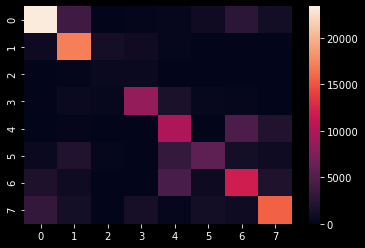

In [7]:
helper.evaluate(pred_rf, y_val)

---
# Post Process

In [10]:
import matplotlib.pyplot as plt

In [30]:
pred = pd.Series(pred_rf)
pred_prob = pred_prob_rf

In [24]:
def plot_prediction(y_pred, y_true):
    plt.figure(figsize = [20, 8])
    plt.plot(y_pred, alpha = 0.4)
    plt.plot(y_true)

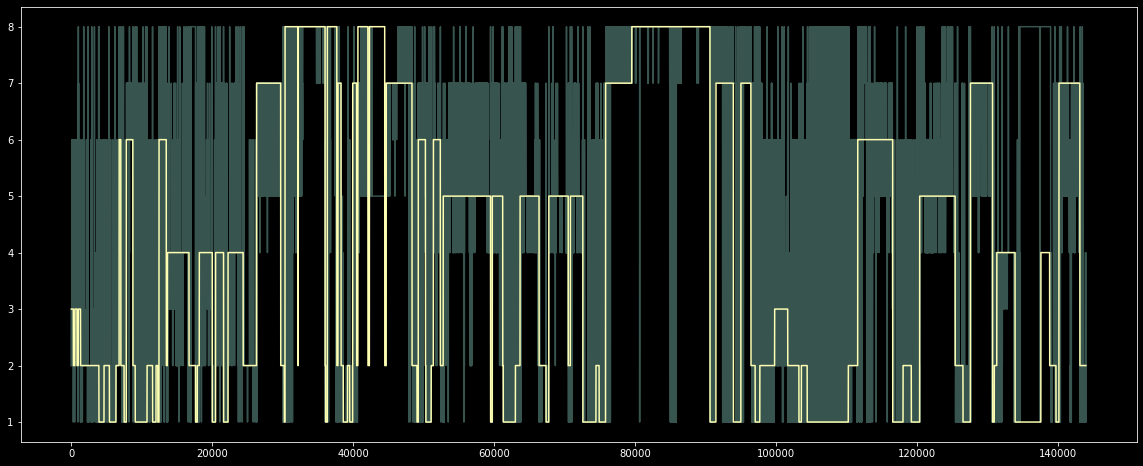

In [27]:
plot_prediction(pred, y_val)

## Mode

In [49]:
pred_mode = pred.rolling(90, center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

[[24879  3318     0   159   395  1105  2816  1220]
 [  190 18807  1451   529   178     8    66     1]
 [    0    22   761   149     0     0     0     0]
 [   89   245   342  9921   856   377   125     1]
 [    4   209     0     0 10534     0  5155  1975]
 [  209  1494   220     0  3380  6032   941   810]
 [ 1399   830     0     0  4890   480 12155  1895]
 [ 3066  1224     0  1273   240  1176   550 15807]]
              precision    recall  f1-score   support

       Still       0.83      0.73      0.78     33892
     Walking       0.72      0.89      0.79     21230
         Run       0.27      0.82      0.41       932
        Bike       0.82      0.83      0.83     11956
         Car       0.51      0.59      0.55     17877
         Bus       0.66      0.46      0.54     13086
       Train       0.56      0.56      0.56     21649
      Subway       0.73      0.68      0.70     23336

    accuracy                           0.69    143958
   macro avg       0.64      0.69      0.65    14

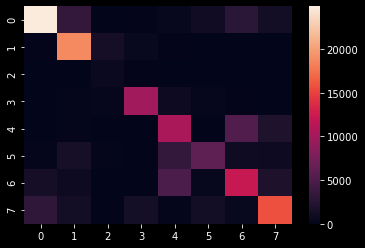

In [50]:
helper.evaluate(pred_mode, y_val)

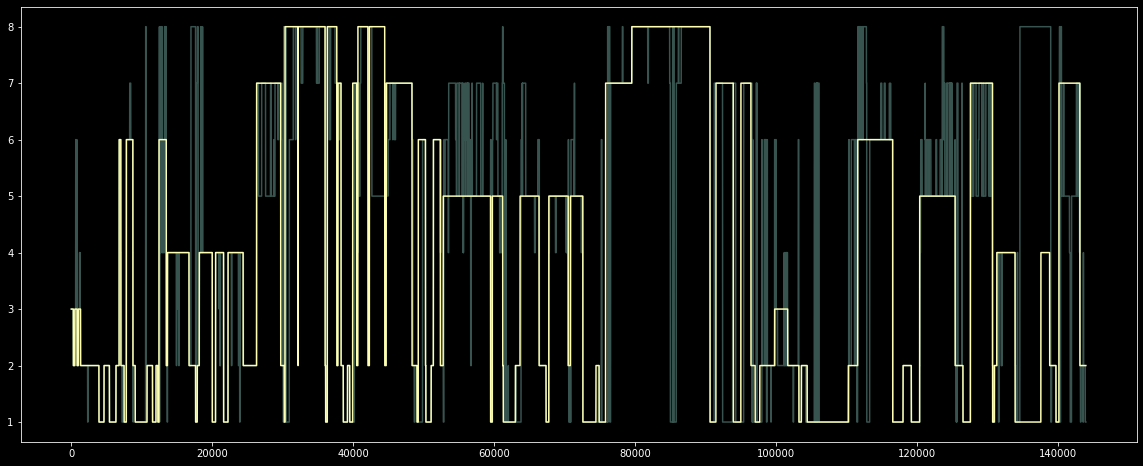

In [51]:
plot_prediction(pred_mode, y_val)

## Mean of Prob

In [63]:
pred_prob_mean = pd.DataFrame(pred_prob).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')

In [64]:
pred_mean = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[24344  3430     0   121   421  1095  2835  1266]
 [  213 18486  1627   745   220    22    52     0]
 [    0    27   836   241     0     0     0     0]
 [   67   131   122  9653   676   230   109     0]
 [   20   211     0     0 10881     0  5190  1970]
 [  189  1846   189     0  3507  6226   768   751]
 [ 1867   786     0     0  4479   577 12350  1753]
 [ 3136  1232     0  1271   289  1028   504 15969]]
              precision    recall  f1-score   support

       Still       0.82      0.73      0.77     33512
     Walking       0.71      0.87      0.78     21365
         Run       0.30      0.76      0.43      1104
        Bike       0.80      0.88      0.84     10988
         Car       0.53      0.60      0.56     18272
         Bus       0.68      0.46      0.55     13476
       Train       0.57      0.57      0.57     21812
      Subway       0.74      0.68      0.71     23429

    accuracy                           0.69    143958
   macro avg       0.64      0.69      0.65    14

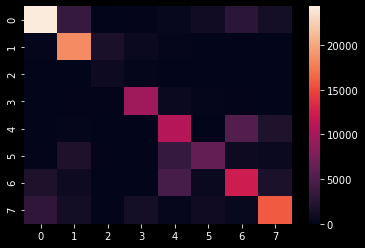

In [65]:
helper.evaluate(pred_mean, y_val)

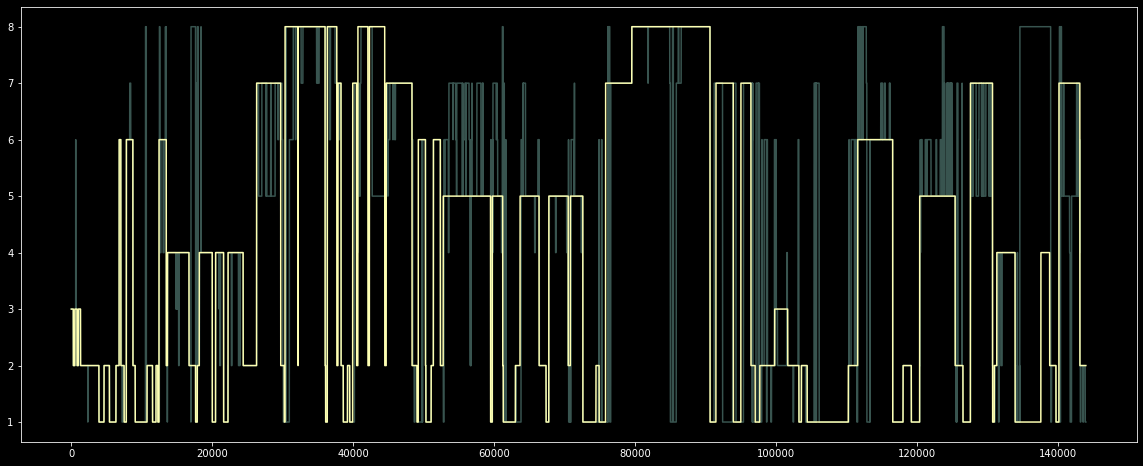

In [66]:
plot_prediction(pred_mean, y_val)

In [73]:
df_tmp = pd.DataFrame({"pred_mode": pred_mode, "pred_mean": pred_mean, "label": y_val})
df_tmp = df_tmp[df_tmp.pred_mode != df_tmp.pred_mean].reset_index(drop = True)

In [81]:
df_tmp['hit2'] = df_tmp.apply(lambda x: int((x['pred_mode'] == x['label']) | (x['pred_mean'] == x['label'])), axis = 1)

In [82]:
Counter(df_tmp['hit2'])

Counter({1: 5755, 0: 1453})

In [86]:
def get_group_conscount(sr):
    groups = groupby(sr.values.tolist())
    grouped_elements = [list(group) for key, group in groups]
    dur_df = pd.DataFrame({"label": [t[0] for t in grouped_elements],
                        "duration": [len(t) for t in grouped_elements]})
    return dur_df

In [108]:
df_dur = get_group_conscount(pred_mean)

In [112]:
# plt.figure(figsize = [12, 6])
# sns.boxplot(x = df_dur['label'], y = df_dur['duration'])
# plt.ylim(0, 400)

In [110]:
df_dur.groupby('label').min()

,duration
label,
1,1
2,1
3,9
4,9
5,1
6,1
7,1
8,1


In [111]:
df_dur[df_dur.duration < 10]

,label,duration
3,6,8
8,3,9
9,2,2
42,8,8
46,1,4
73,2,6
184,7,8
210,5,9
225,2,1
227,2,4


In [99]:
df_dur.shape

(457, 2)

In [104]:
df_dur = get_group_conscount(y_val)

<AxesSubplot:xlabel='label', ylabel='duration'>

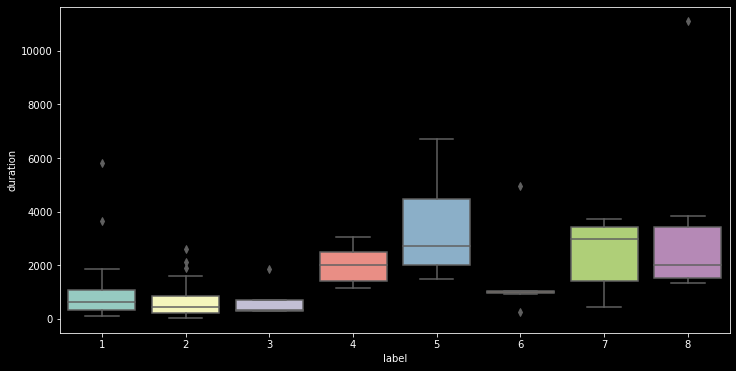

In [106]:
plt.figure(figsize = [12, 6])
sns.boxplot(x = df_dur['label'], y = df_dur['duration'])

In [107]:
df_dur.groupby('label').min()

,duration
label,
1,106
2,30
3,285
4,1140
5,1484
6,241
7,434
8,1350


In [ ]:
def smooth

In [ ]:
index_set = 0
for i in range(index_set, )